## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Part IV - Conclusions](#conclusions)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. 

For this project, we will be working to understand the results of an A/B test run by an e-commerce website. the goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [133]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure the reproducibility of the code
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [134]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [135]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [136]:
df["user_id"].nunique()

290584

d. The proportion of users converted.

In [137]:
df["converted"].sum()/df["user_id"].nunique()

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't match.

In [138]:
df.query('group == "treatment" & landing_page !="new_page"').shape[0] + df.query('group != "treatment" & landing_page =="new_page"').shape[0]

3893

f. Do any of the rows have missing values?

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


thankfully , we don't

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

In [140]:
df.drop(df.query('group == "treatment" & landing_page !="new_page"').index, inplace = True)
df.drop(df.query('group != "treatment" & landing_page =="new_page"').index, inplace = True)


In [141]:
df2=df

In [142]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [143]:
 df2.shape[0] ,df2.user_id.nunique()

(290585, 290584)

b. There is one **user_id** repeated in **df2**.  What is it?

In [144]:
df[df2.duplicated(subset=['user_id'])].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [145]:
df[df2.duplicated(subset=['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [146]:
df2.drop_duplicates(subset=['user_id'] , inplace =True )

`4.` 

a. What is the probability of an individual converting regardless of the page they receive?

In [147]:
df2["converted"].sum()/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [148]:
#first let's calculate the propability of being in the control group and converted
numerator = df2.query('group == "control" & converted ==  1').shape[0]/df2.shape[0]
#now let's calculate the propapility of being in the control group
denominator = df2.query('group == "control"').shape[0]/df2.shape[0]
#finally to answer the question 
p1 = numerator/denominator
p1

0.12038630450046119

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [149]:
#first let's calculate the propability of being in the treatment group and converted
numerator = df2.query('group == "treatment" & converted ==  1').shape[0]/df2.shape[0]
#now let's calculate the propapility of being in the control group
denominator = df2.query('group == "treatment"').shape[0]/df2.shape[0]
#finally to answer the question 
p2 = numerator/denominator
p2

0.11880806551510564

d. What is the probability that an individual received the new page?

In [150]:
df2[df2["landing_page"]=="new_page"].shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Absolutely not a sufficient evidence to favour the new treatment page ove the old page . Although it looks like that the control group has a slightly higher conversion rate (0.1203) than the treatment group (0.1188) , but that could bevdue to other factors like change resistence or test time duration so in order to have a stronger statement regarding our A/B test result , a hypothesis testing needed** 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{old} - p_{new} \ge 0$$


$$H_1: p_{old} - p_{new} < 0$$


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [151]:
# p_old = p_new = converted rate in ab_data.csv regardless of the page
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [152]:
# p_old = p_new = converted rate in ab_data.csv regardless of the page
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [153]:
n_new = df2.query("group == 'treatment'").shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [154]:
n_old = df2.query("group == 'control'").shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [155]:
new_page_converted = np.random.choice([0,1], p=[1-p_new, p_new], size=[1,n_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [156]:
old_page_converted = np.random.choice([0,1], p=[1-p_old, p_old], size=[1,n_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [157]:
# difference in simulated values

diff = new_page_converted.mean() - old_page_converted.mean()

diff

-0.000587099005376221

**why we calculated the mean?**
Because of a size mis-match so if we were to calculate the difference of $p_{new}$ - $p_{old}$ that would give an error .

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [158]:
#bootstrabing
# 10000 simulations for difference of p_new and p_old


new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [159]:
# Calculate the actucl difference observed in ab_data
x=df2.query('group =="treatment"').converted.mean()-df2.query('group =="control"').converted.mean()
x

-0.0015782389853555567

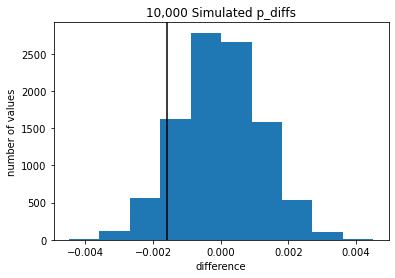

In [160]:
# plotting histogram for simulated data

plt.hist(p_diffs);
plt.axvline(x=x, color='black');
plt.xlabel('difference');
plt.ylabel('number of values');
plt.title('10,000 Simulated p_diffs');

the plot looks like what we would expect due to the bootstrapping technique


j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [161]:
p_value = (p_diffs > x).mean()

p_value

0.9043

In [162]:
p_value < 0.05

False

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**in the previous part "j" we computed the p_value which is the probability of getting a sample as extreme as ours given the null hypothesis is true**


**Since we conducted our hypothesis test on a 5% level of significant and we found that the p_value is bigger than 0.05 , the result of the hypothesis test:
we fail reject to the null hypothesis at 5% level of significant**


**that means that the we failed to prove that the new page increases the portion of conversion at 5% level of significant**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [163]:
import statsmodels.api as sm

convert_old = sum(df2.query("group == 'control'")['converted'])
convert_new = sum(df2.query("group == 'treatment'")['converted'])
n_old = len(df2.query("group == 'control'"))
n_new = len(df2.query("group == 'treatment'"))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [164]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new],[n_old, n_new], alternative='larger')
z_score, p_value

(1.3109241984234394, 0.09494168724097551)

In [165]:
# importing scipy
from scipy.stats import norm
# using the normal cumulative distribution function
norm.cdf(z_score)

0.9050583127590245

In [166]:
# calculating critical value for our z-test
critical_value = norm.ppf(1-(0.05/2))
critical_value

1.959963984540054

In [167]:
# checking test result
test_result_2 = (z_score > critical_value)
test_result_2

False

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Results above deduced a z_score of 1.31. Since this value does not exceed the critical value at 95% confidence interval (1.96); there is no statistical evidence to reject the null hypothesis. Furthermore, p-value obtained is similar to the result obtained from our previous findings in j. and k. which also fails to reject the null hypothesis as it provides evidence of a higher probability of the null hypothesis**.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**logistic regression since taht there're only two possible outcomes for eash case**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [168]:
df2['intercept'] = 1
df2[['ab_page2', 'ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('ab_page2', axis = 1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import the regression model.  Instantiate the model, and fit the model using the two columns created in part **b.** to predict whether or not an individual converts.

In [169]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [170]:
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2020-12-23 19:21 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>

**The p-value associated with ab_page was 0.19 which was significantly lower than the one in Part II which was approximately 0.9. The reason for such a significant difference is because the null and alternative hypothesis differed in each exercise.**

**<u>Part II Case:</u>**
$$H_0: p_{old} - p_{new} \ge 0$$


$$H_1: p_{old} - p_{new} < 0$$

**<u>Logistic Regression Case:</u>**
$$H_0: p_{old} = p_{new}$$


$$H_1: p_{old} \ne p_{new}$$

**$p_{old}$ and $p_{new}$ are the converted rates for the old and new pages respectively.**

**Because the later case relies solely on two possible outcomes, it may be the reason that it yields a lower probability in the null hypothesis than that in the case in Part II of the earlier exercise.**

f. Now, we shall consider other things that might influence whether or not an individual converts.  The below section discusses why it is a good idea to consider other factors to add into your regression model along with  disadvantages to adding additional terms into your regression model?

**<u>Advantages:</u>**<br>

- Allows for a more sophisticated model to distinguish other factors which may contribute to the outcome.
- May be used to identify outliers.<br>

**<u>Disdvantages:</u>**<br>

- May produce inaccurate results due to correlated errors.<br>

g. Now along with testing if the conversion rate changes for different pages, we will also add an effect based on which country a user lives. First, we will need to read in the **countries.csv** dataset and merge together both datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion? We will provide the statistical output as well as a written response to answer this question.

In [171]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


Check number of unique rows under country column:

In [172]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

Considering there are three dummy variables, we will need to include two columns.

In [173]:
df_new[['UK', 'US']] = pd.get_dummies(df_new['country'])[['UK','US']]

df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


Computing the statistical output:

In [174]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'US', 'UK']])

In [175]:
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2020-12-23 19:21 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
==================================================================

"""

**According to our statistical output the p-value for both countries yields a value larger than 0.05; hence, there is no statistical evidence on country's significant impact on conversion.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  

We will create the necessary additional columns, and fit the new model then provide the summary results, and conclusions based on the results.

**Pages** column is already included as per exercise in part b); hence, model may be made similar to previous part while including **pages** column.

In [176]:
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']
df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,US_ab_page,UK_ab_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,0,1


In [177]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'US_ab_page','UK_ab_page']])

In [178]:
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.7674
Date:               2020-12-23 19:21 BIC:              212813.5064
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.31643    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9926    0.0079  -252.9104  0.0000  -2.0081  -1.9772
US_ab_page   -0.0144    0.0125    -1.1548  0.2482  -0.0389   0.0101
UK_ab_page    0.0112    0.0179     0.6256  0.5316  -0.0240   0.0464
==================================================================

"""

**According to results above, even after adding <u>US_ab_page</u> and <u>UK_ab_page</u> there does not seem to be any statistical evidence to indicate an impact on the conversion since p-values were all exceeding 0.05.**

<a id='conclusions'></a>



## conclusions
 **the conditional probability , hypothesis testing and logistic regression all reached the Same result which we fail to reject the null hypothesis which is "the new page won't have a better conversion rate than the old page" so given that I would recommend not to launch the new page but to carry on with the test for some more time for future analysis which may change our numbers and our minds too .**
 



In [179]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0